## History of "literature" - Co-occurrence in Hathi Trust

So, to pick up where we left off last time. Over the course of the last two weeks, I've completed a first pass of the page-level co-occurrence analysis, which turned out to be a bit more complex than I thought - though in some really interesting ways. After getting the overall counts for each token in each year (the "baseline" counts that I showed before), the next step was to extract a second, filtered set of counts that would record the number of times each word appeared on pages that contain "literature." Put together, these two sets of counts give us the building blocks that we need to track the diachronic change in a word's association with literature - find words that have a particularly dynamic or "trending" relationship with literature over time.

We're now storing two different types of counts in two tables:

```sql
CREATE TABLE count (
	token VARCHAR NOT NULL, 
	year INTEGER NOT NULL, 
	count INTEGER NOT NULL, 
	PRIMARY KEY (token, year)
);
CREATE TABLE anchored_count (
	token VARCHAR NOT NULL, 
	year INTEGER NOT NULL, 
	anchor_count INTEGER NOT NULL, 
	count INTEGER NOT NULL, 
	PRIMARY KEY (token, year, anchor_count)
);
```

The `count` table stores the overall, unfiltered counts for words on all pages, broken out by year. Eg:

**`"literature" / 1900 / 89608`**

Meaning, "literature" appears 89,608 times in 1900. Meanwhile, `anchored_count` stores counts just for words that appear on pages that contain "literature," broken out by the year and by the number of times that "literature" itself appears on the page in question. (This will allow us to dig into the question of whether there's a difference between pages that are really _about_ literature, as opposed to pages that just use the word in passing.) Eg:

**`"poetry" / 1900 / 4 / 5967`**

Meaning - in 1900, "poetry" appears 5,967 times on pages where "literature" appears 4 times. In total, the extraction run chewed through all ~820k volumes in the Harvard collection in Hathi Trust, and observed a total of **43.5 billion** tokens:

In [1]:
from hol.models import Count, AnchoredCount

print(Count.total_token_count())

43401065888


Which is still only about 1/5 of the whole collection. It turns out, the Harvard collection is basically a C19 corpus. Here's the overall volume trend:

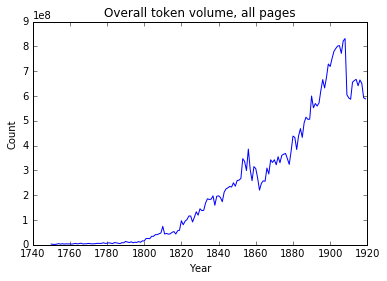

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

years = range(1750, 1920)

series = Count.year_count_series(years)

plt.title('Overall token volume, all pages')
plt.xlabel('Year')
plt.ylabel('Count')
plt.plot(*zip(*series.items()))

## Log-likelihoods, ranked and scaled

So, two sets of counts - one for all pages, and the other just for pages that contain "literature." Even though both are drawn from the same corpus, we can think of them as representing two separate corpora - the corpus of "literature" pages, and the corpus of all pages, a sub-corpus and a super-corpus. The objective - which words appear in the literature corpus at a higher-than-expected rate, when compared against the overall frequencies in the super-corpus?

There are a couple of ways to go about this - a log-likelihood tests, the Mann-Whitney ranks test, and others. The log-likelihood is the most canonical and straightforward, though, so let's start with that. To measure the distinctiveness of "great" in 1900, we need 4 pieces of information:

In [21]:
a = AnchoredCount.token_year_count('great', 1900)
print('The number of times "great" appears on pages that contain "literature":')
print(a, '\n')

b = Count.token_year_count('great', 1900)
print('The number of times "great" appears on all pages:')
print(b, '\n')

c = AnchoredCount.year_count(1900)
print('The total number of tokens observed on pages that contain "literature":')
print(c, '\n')

d = Count.year_count(1900)
print('The total number of tokens observed on all pages:')
print(d)

The number of times "great" appears on pages that contain "literature":
41986 

The number of times "great" appears on all pages:
925673 

The total number of tokens observed on pages that contain "literature":
23646454 

The total number of tokens observed on all pages:
719028426


Then, we can use scipy's `chi2_contingency` function to calculate the log-likelihood:

In [4]:
import numpy as np

from scipy.stats import chi2_contingency

g, p, dof, exp = chi2_contingency(
    np.array([[a, b], [c, d]]),
    lambda_='log-likelihood',
)

print(g)

3765.27132696


This is expensive to compute for an individual word, but it can be sped up by querying big batches of counts and calculating the scores in bulk. These get shoveled into a `score` table, which stores the token, year, and log-likelihood ("score"):

```sql
CREATE TABLE score (
	token VARCHAR NOT NULL, 
	year INTEGER NOT NULL, 
	score FLOAT NOT NULL, 
	PRIMARY KEY (token, year)
);
```

So, once we've filled in this table with log-likelihood scores for each token in each year, we can generate a list of the words in a given year that are most associated with literature. Here's the list for 1900, pulling from pages that contain literature more than 3 times:

In [11]:
import pprint

from collections import OrderedDict
from hol.models import Score

topn = Score.topn_by_year(1900, 50)
    
pp = pprint.PrettyPrinter()
pp.pprint(topn)

OrderedDict([('english', 11343.758863638539),
             ('literary', 9269.245377038995),
             ('history', 7702.690766636572),
             ('professor', 6936.655142529855),
             ('books', 6115.275516958516),
             ('language', 4836.8724286320175),
             ('book', 4441.464551126228),
             ('study', 4368.438716046283),
             ('poetry', 3979.5542975552166),
             ('library', 3756.0847292648536),
             ('of', 3227.2424626878637),
             ('university', 3195.9592170553415),
             ('reading', 3048.035788981686),
             ('authors', 3016.0386818292836),
             ('prose', 2924.5628235120166),
             ('american', 2894.2817624782965),
             ('century', 2863.7580836209354),
             ('author', 2626.9518352891346),
             ('writers', 2611.612610123155),
             ('edited', 2466.8276362267034),
             ('work', 2168.908138609032),
             ('poems', 2139.6277953710187),
           

Looks sensible, with a couple curiosities ("of"?), which I'll get into later. So now, with this, the next step is to pull these stats for each year, and string together time-series signals for each word to get a diachronic progression of it's stickiness with literature. But, out-of-the-box, this doesn't work. The problem is that the log-likelihood scores can be used to compare words within an individual year, but not _across_ years, because the values are boosted by the overall volumes of the tokens. This is actually a feature of the log-likelihood, not a bug - when scoring a word, it rewards tokens that both (a) have a higher-than-expected frequency in the analysis corpus and (b) have a high overall frequency in the reference corpus. This is important, because otherwise the top of the list would be swamped by very infrequent words. For instance, something that was expected to appear 1 time but actualy appeared 5 times. If you just compare the values directly, this comes out to a 500% increase over the expected. But, since the numbers are so small, this could just be a fluke - a single page out of millions. The intuition behind log-likelihood is that we care much more about a word that's expected to appear 1,000 times but actually occurs 1,200. Just a 20% increase, but we can say with much more confidence that the difference is meaningful.

So, log-likelihood is great for ranking words inside of a single year, but if we string the raw scores together into a time series, we end up just proxying the overall volume trend. For example, here's the log-likelihood series for "history":

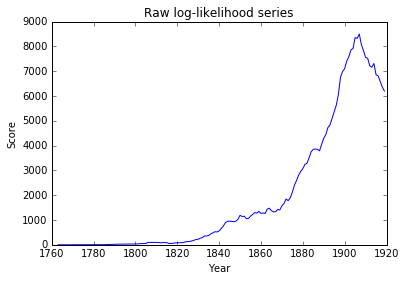

In [15]:
years = range(1750, 1920)

series = Score.score_series_smooth('history', years)

plt.title('Raw log-likelihood series')
plt.xlabel('Year')
plt.ylabel('Score')
plt.plot(*zip(*series.items()))

And the baseline frequency trend for "history":

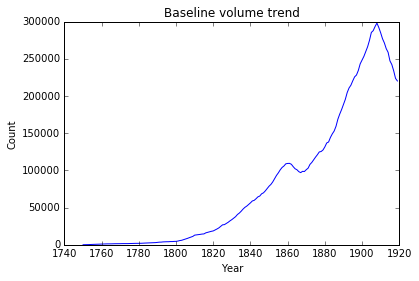

In [14]:
years = range(1750, 1920)

series = Count.token_count_series_smooth('history', years)

plt.title('Baseline volume trend')
plt.xlabel('Year')
plt.ylabel('Count')
plt.plot(*zip(*series.items()))

This is the same data, essentially, just with different units. We need a way to normalize the magnitudes of the log-likelihoods, similar to the words-per-million scaling that we use on the overall frequencies. This turns out to be a tricky and interesting problem. At first, I tried just scaling everything down to "unit variance" - slide and compress the scores so that they center around 0 and have a variance of 1. But, when I plotted the transformed scores, the trend lines were basically unchanged - still just a proxy for volume.

This doesn't work, I think, because _the total number of unique word forms in a year increases along with the overall volume_. In other words, if we see 1,000 total tokens in the year 1800 and 100 unique words, then in 1900 there might be 10,000 total tokens but _1,000_ unique words, not just more occurrences of the same set of 100. Most of these new words will be un-correlated with "literature," which has the effect of packing in lots of low-correlation words right around the mean at 0. Which, in turn, allows the high-magnitude outliers (the ones we care about) to creep further and further away from 0 over time - shadowing the overall volume - even though the variance is pagged at 1.

Next, I tried this - for each year, use the log-likelihoods to compute a rank order for each word. So, if there are N word forms for the year, the most correlated word has a rank of N, and the least correlated has a rank of 1. Since N grows over time, I then scaled these ranks down to a 0-1 scale and plotted time series for the normalized ranks. But, this fails for the same reason - over time, as the size of the corpus increases and more and more word types come into view, words get packed into the bottom of these rankings, which has the effect of artificially pushing up the ranks of the high-correlation words. Not because of any meaningful change in their correlation with literature, but just to make room for all the new, uncorrelated words that have to get crammed into the bottom of the stack.

## Vocabulary cropping

In both cases, the root of the problem is this monotonic growth in the size of the vocabulary - as new words pour into the system, the correlation scores get artificially shoved upwards, which drowns out the meaingful fluctuations that we care about. How to fix this? Could we somehow crop down the vocabulary, identify a fixed subset of words that are meaningful across time?

Here's what I came up with:

1. For each year, compute log-likelihoods for all words and generate a 500-word "depth chart," like the one above. This represents the 500 words that are most significantly correlated with literature in that year.

1. Loop through all of these lists and build up a set of unique word forms that appear in _any_ of the lists. This gives a set of ~5,000 words that are highly correlated with "literature" in any year between 1750 and 1920.

1. For each word in this cropped-down set, generate a time-series out of the word's position in the per-year ranks. Eg, for year X, if word Y is at the bottom of the list, it gets a score of 1, or if it's at the top, 500.

So, to circle back to "history":

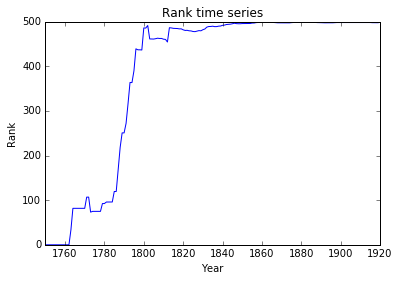

In [18]:
from hol.topn_series import TopnSeries

years = range(1750, 1920)

topns = TopnSeries(years)

series = topns.rank_series_smooth('history')

plt.title('Rank time series')
plt.xlabel('Year')
plt.ylabel('Rank')
plt.xlim(1750, 1920)
plt.plot(*zip(*series.items()))
plt.show()

History rockets to the top of the stack between 1890 and 19000, and stays almost (when not exactly) at the top through 1920 - a far cry from the raw log-likelihood signal:

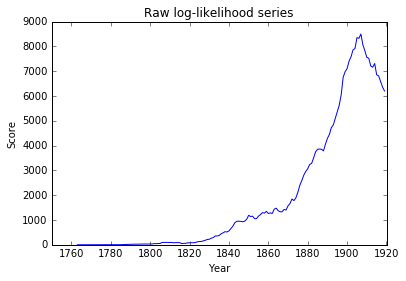

In [20]:
years = range(1750, 1920)

series = Score.score_series_smooth('history', years)

plt.title('Raw log-likelihood series')
plt.xlabel('Year')
plt.ylabel('Score')
plt.xlim(1750, 1920)
plt.plot(*zip(*series.items()))

## Interesting words

Now, the final step - given the set of ~5k words that show up near the top of the correlation stacks with "literature" at some point between 1750 and 1920, how do we find words with _interesting_ signals - words that have a dynamic relationship with literature, that rise and fall dramatically over time. This is essentially a signal processing problem, and there are a number of ways we could go about it, I think.

To start, though, I took a (very) simple approach - just compute the raw variance of the values in the time series. This actually seems to do a fairly good job - take a look at the appendix for a complete listing of the top 500 words, ranked in terms of signal variance. I think there's some very interesting stuff here. I won't go into it in too much detail at this point, other than to call out a handful of things that caught my eye.

### Pedagogy

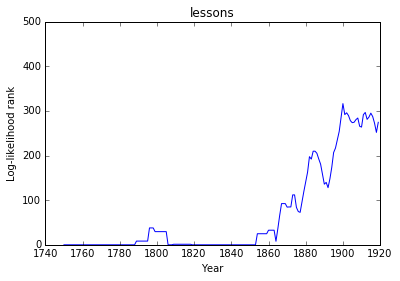

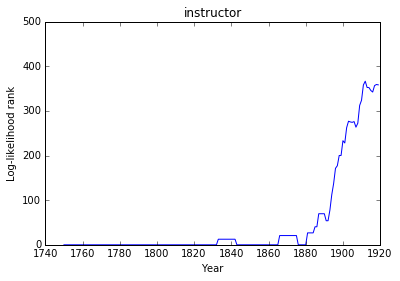

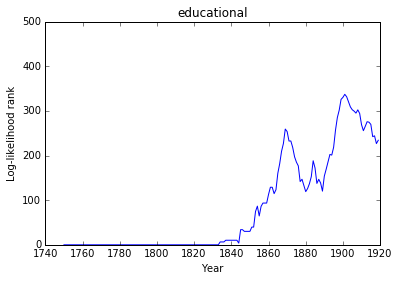

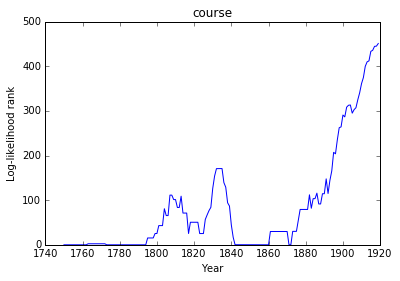

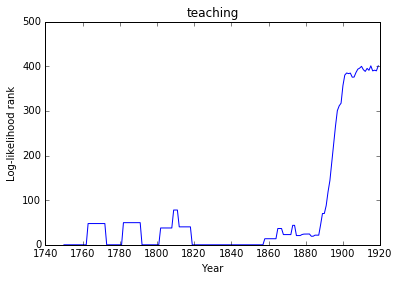

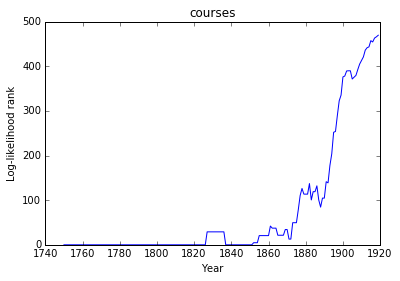

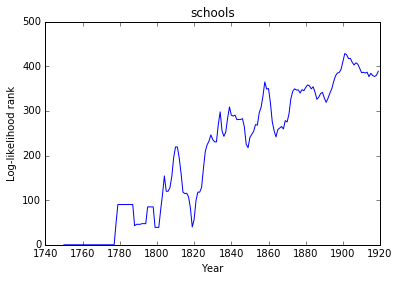

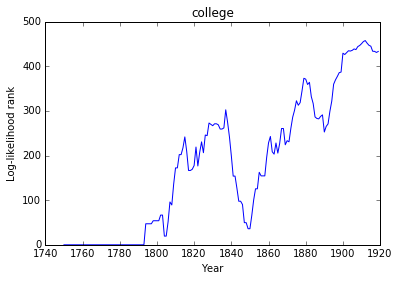

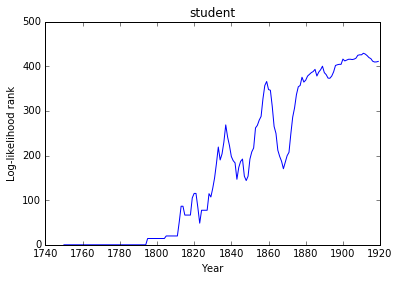

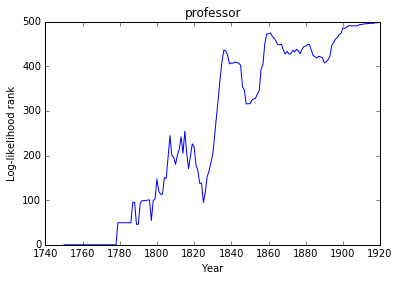

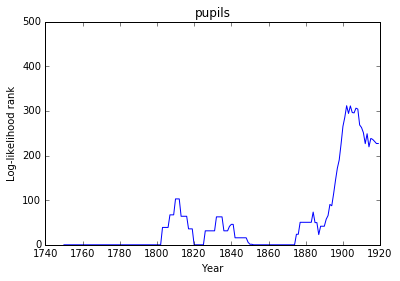

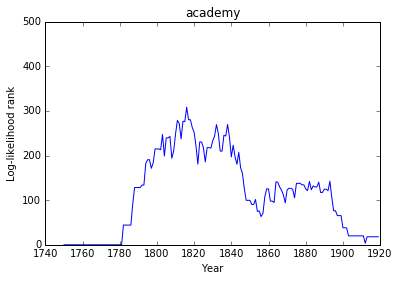

In [36]:
def plot_ranks(tokens):    
    for token in tokens:

        years = range(1750, 1920)
        series = topns.rank_series_smooth(token)

        plt.title(token)
        plt.xlabel('Year')
        plt.ylabel('Log-likelihood rank')
        plt.ylim(0, 500)
        plt.plot(*zip(*series.items()))
        plt.show()
    
plot_ranks([
    'lessons',
    'instructor',
    'educational',
    'course',
    'teaching',
    'courses',
    'schools',
    'college',
    'student',
    'professor',
    'pupils',
    'academy',
])

### Business

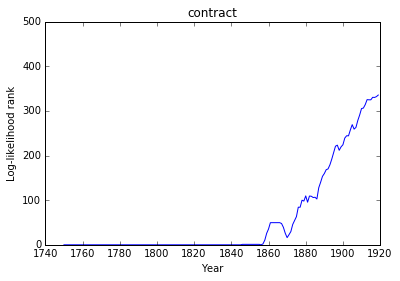

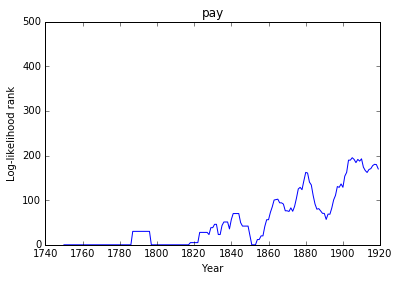

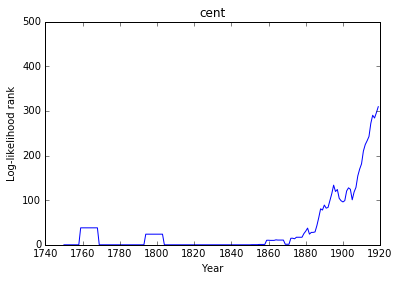

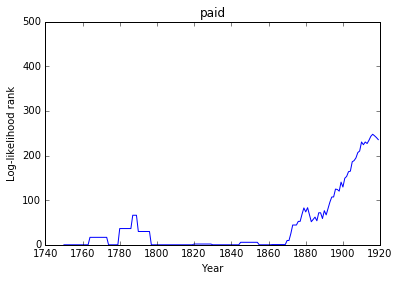

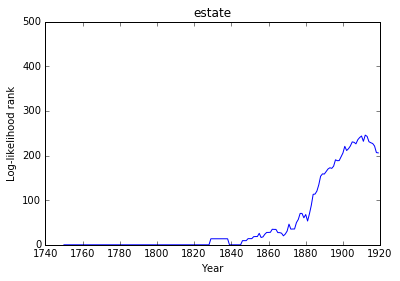

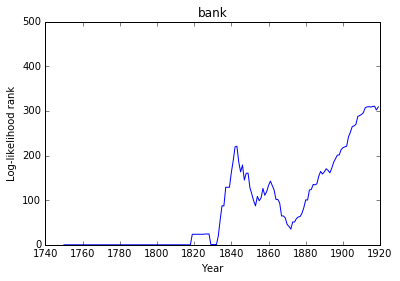

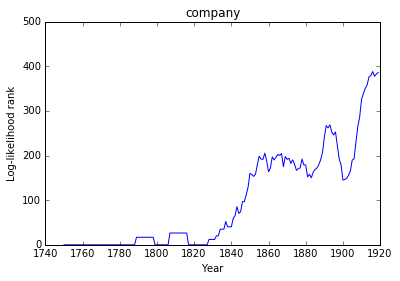

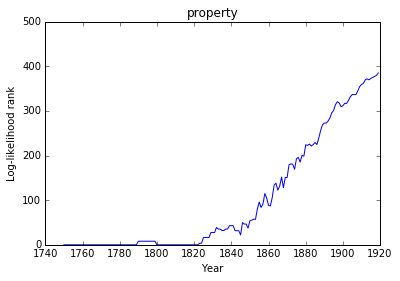

In [28]:
plot_ranks([
    'contract',
    'pay',
    'cent',
    'paid',
    'estate',
    'bank',
    'company',
    'property',
])

### Religion

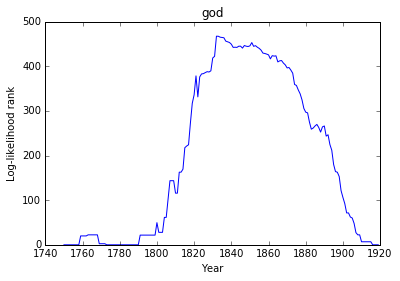

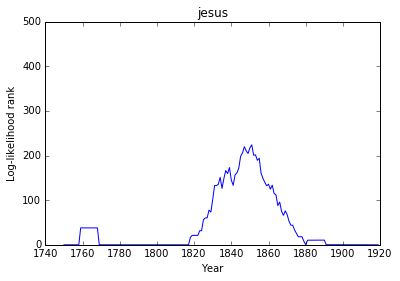

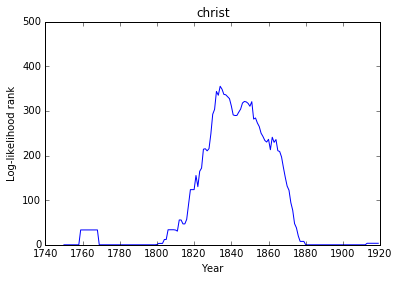

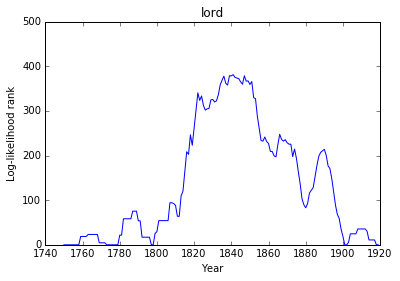

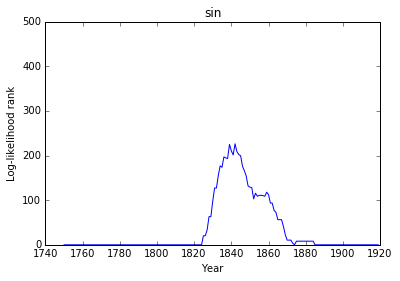

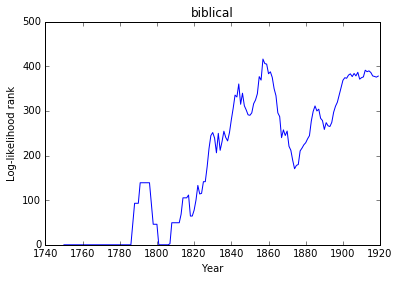

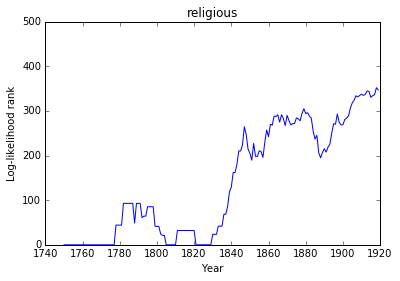

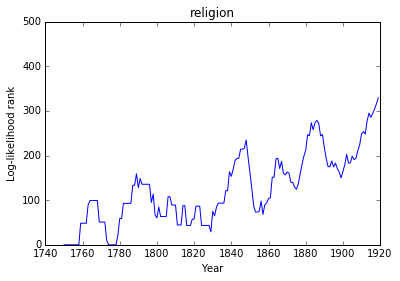

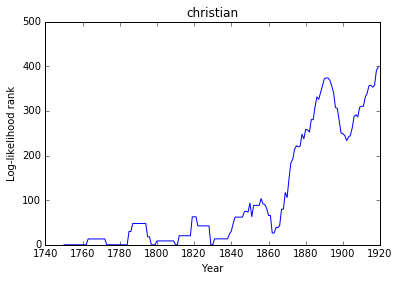

In [31]:
plot_ranks([
    'god',
    'jesus',
    'christ',
    'lord',
    'sin',
    'biblical',
    'religious',
    'religion',
    'christian',
])

### Scholarship

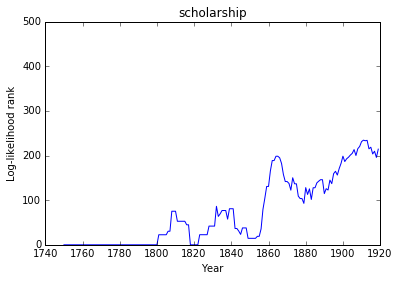

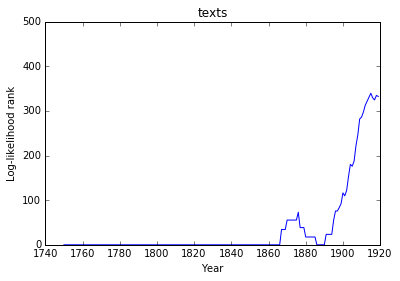

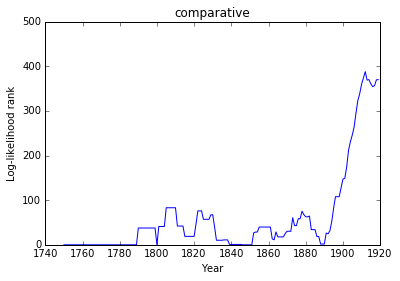

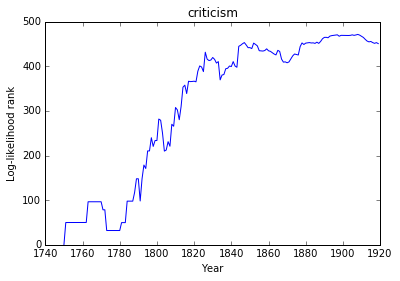

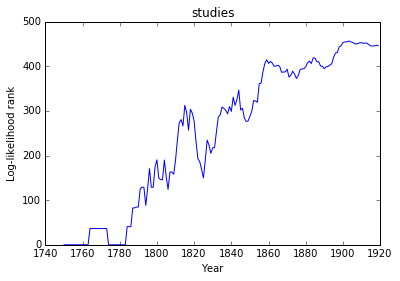

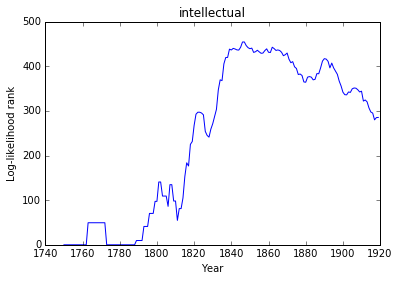

In [32]:
plot_ranks([
    'scholarship',
    'texts',
    'comparative',
    'criticism',
    'studies',
    'intellectual',
])

### Periods

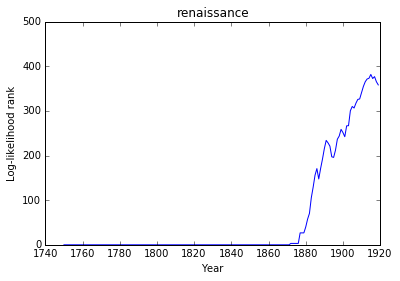

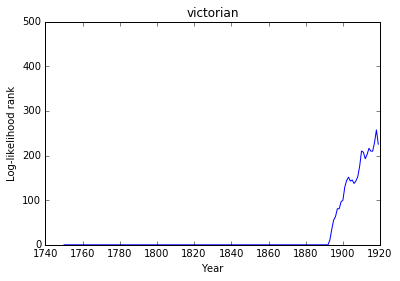

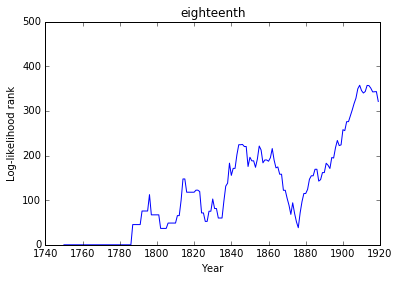

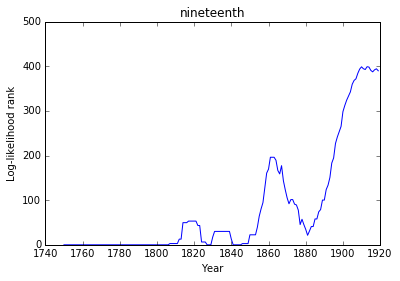

In [33]:
plot_ranks([
    'renaissance',
    'victorian',
    'eighteenth',
    'nineteenth',
])

### Genres and formats

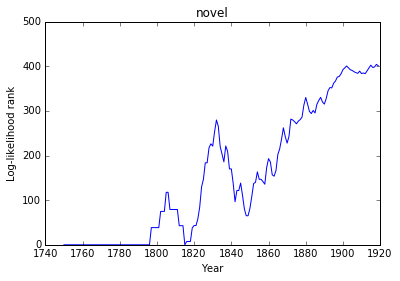

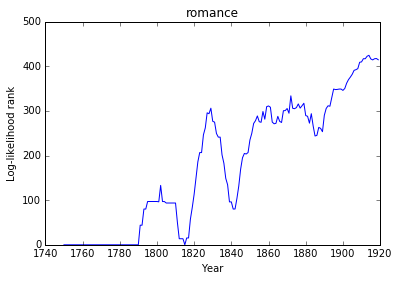

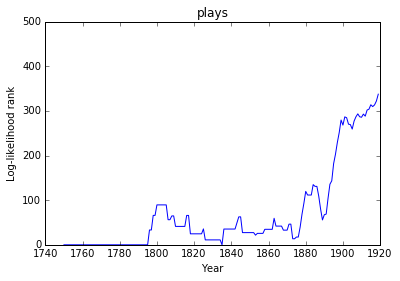

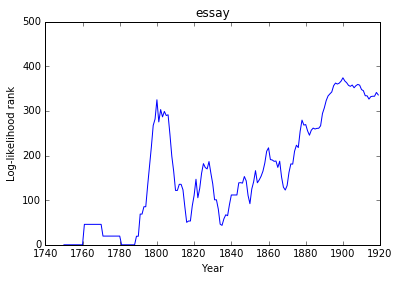

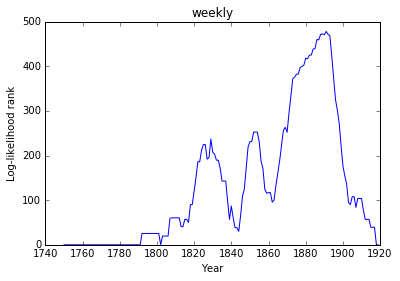

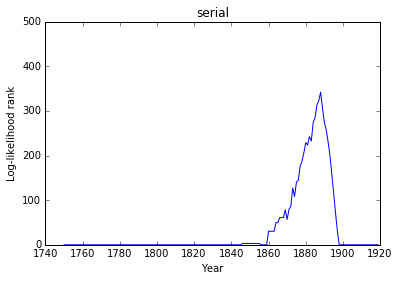

In [35]:
plot_ranks([
    'novel',
    'romance',
    'plays',
    'essay',
    'weekly',
    'serial',
])

### Self-improvement, pleasure

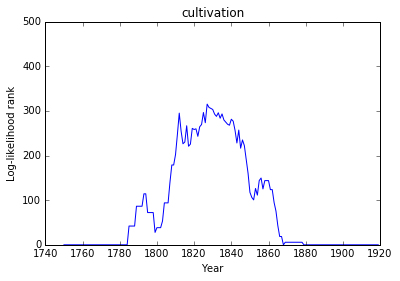

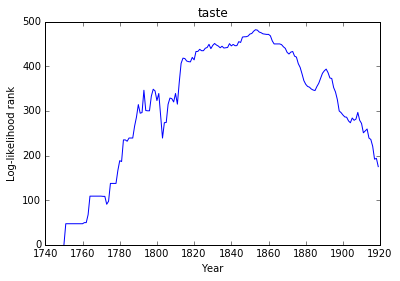

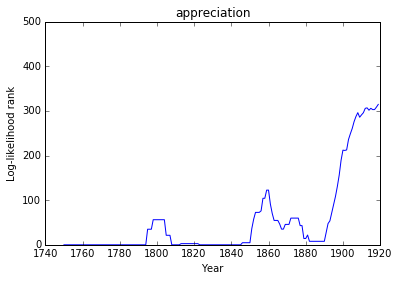

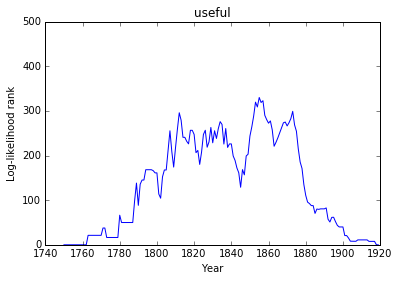

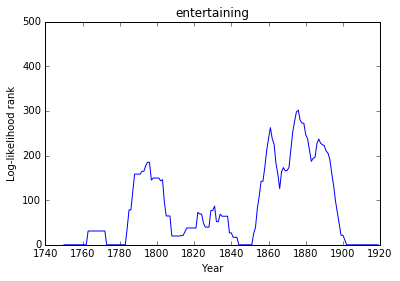

In [38]:
plot_ranks([
    'cultivation',
    'taste',
    'appreciation',
    'useful',
    'entertaining',
])

### Authors

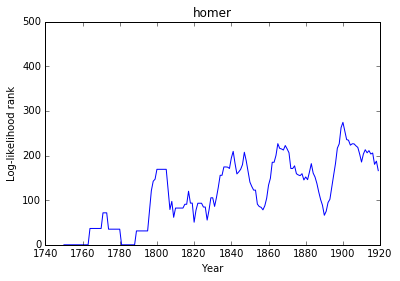

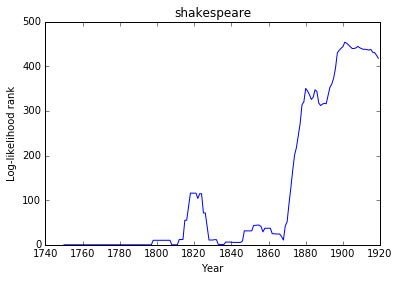

In [39]:
plot_ranks([
    'homer',
    'shakespeare',
])

### The sciences, hard and soft

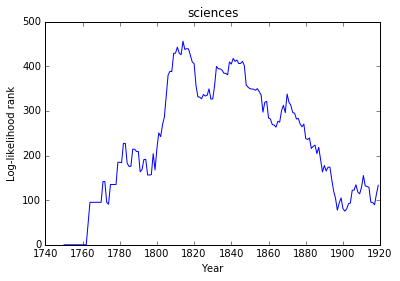

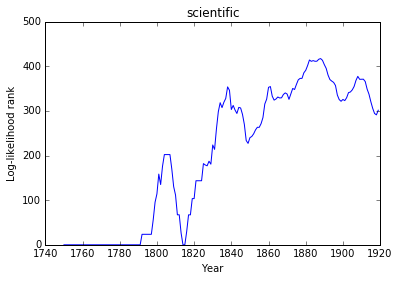

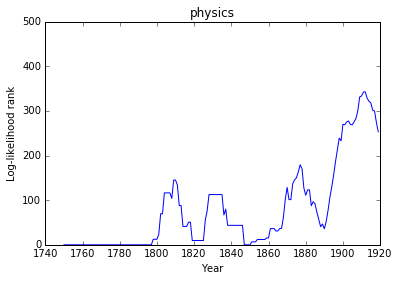

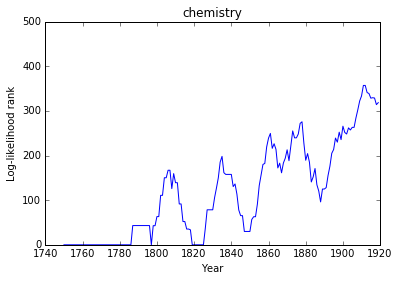

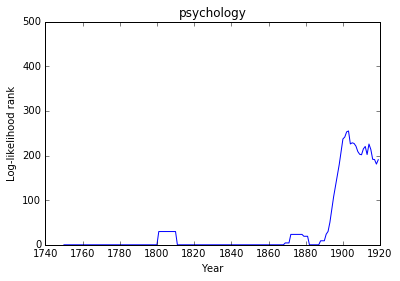

In [41]:
plot_ranks([
    'sciences',
    'scientific',
    'physics',
    'chemistry',
    'psychology',
])

### Cleverness

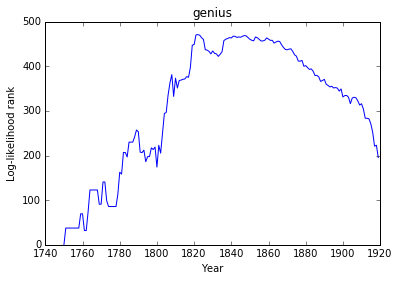

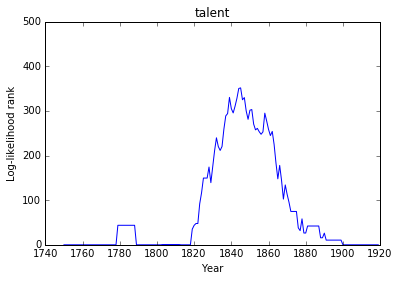

In [42]:
plot_ranks([
    'genius',
    'talent',
])

### Appraisal, judgement

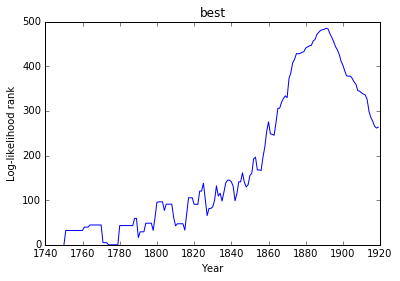

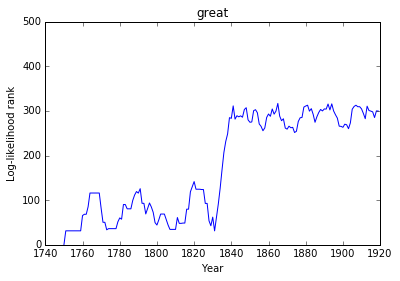

In [45]:
plot_ranks([
    'best',
    'great',
])

### Gender

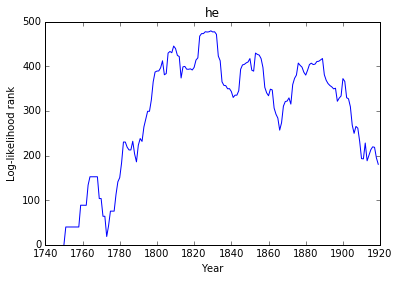

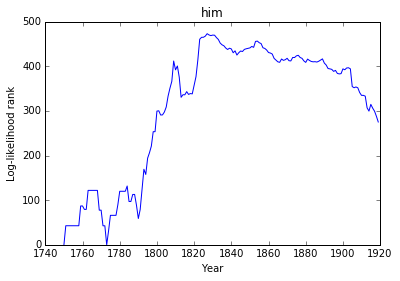

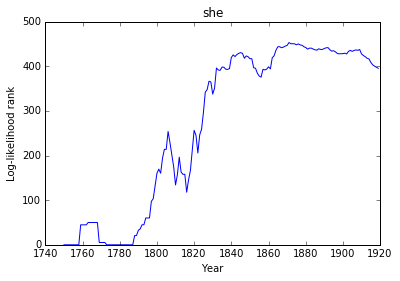

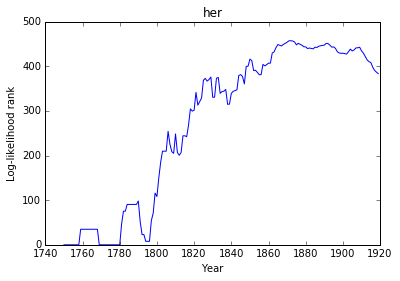

In [43]:
plot_ranks([
    'he',
    'him',
    'she',
    'her'
])

### The first person

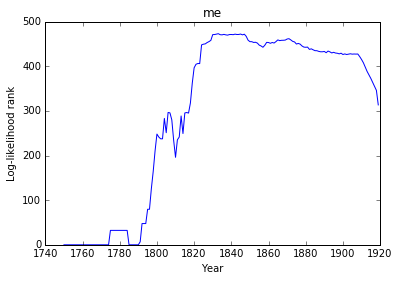

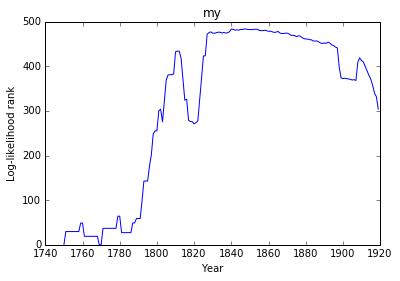

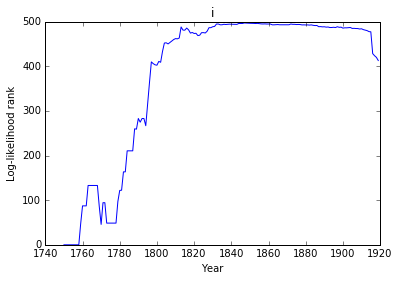

In [44]:
plot_ranks([
    'me',
    'my',
    'i',
])

### Nationalities, ethnicities, regions

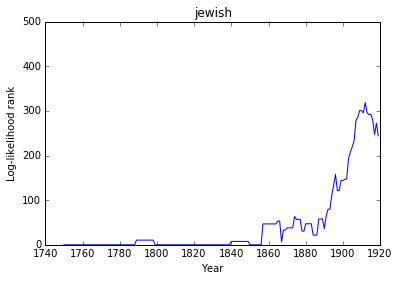

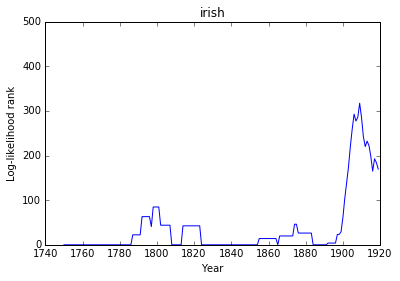

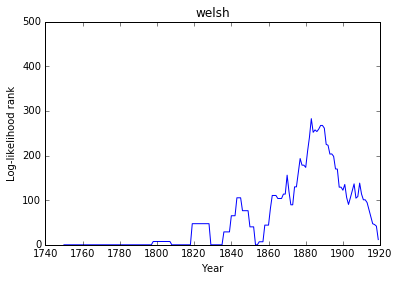

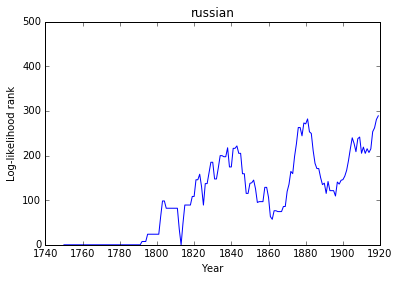

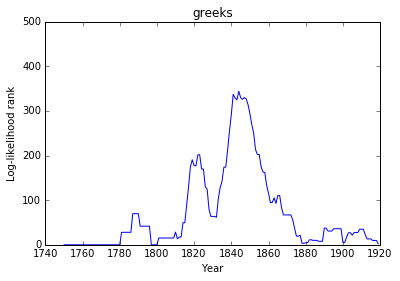

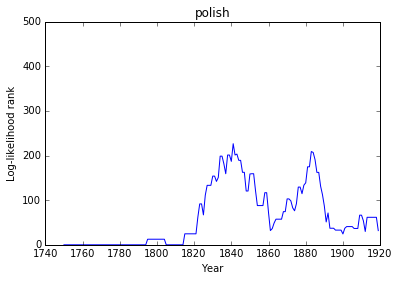

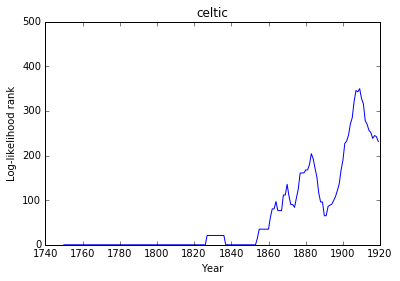

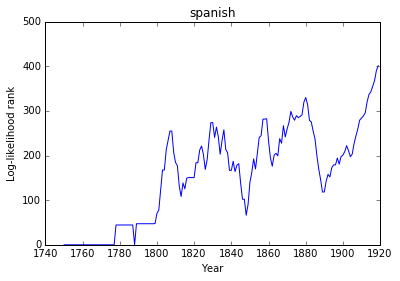

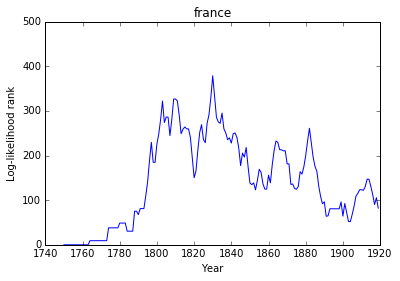

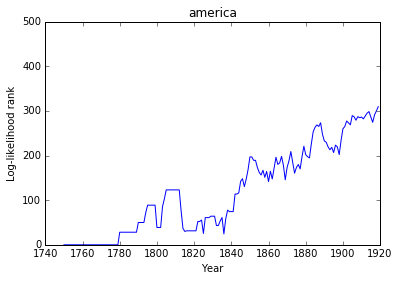

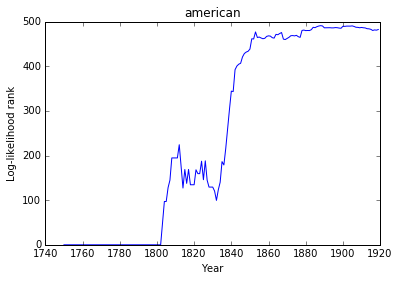

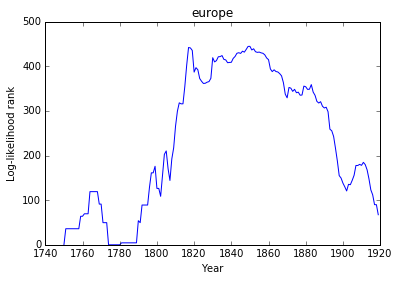

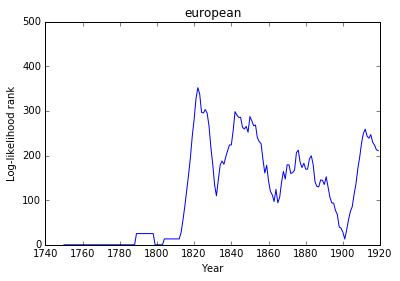

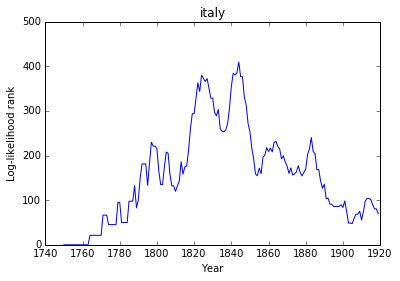

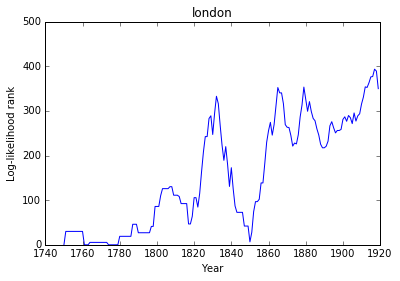

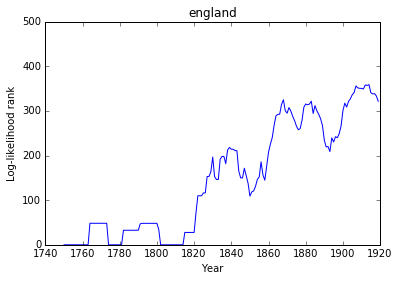

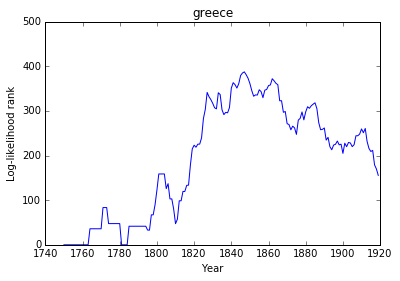

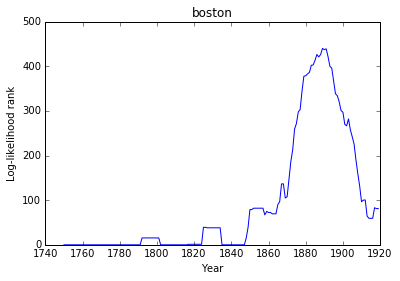

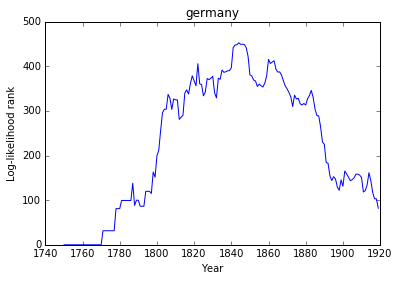

In [46]:
plot_ranks([
    'jewish',
    'irish', 
    'welsh',
    'russian',
    'greeks',
    'polish',
    'celtic',
    'spanish',
    'france',
    'america',
    'american',
    'europe',
    'european',
    'italy',
    'london',
    'england',
    'greece',
    'boston',
    'germany',
])